Read GeoTIFF

In [46]:
#pip install rasterio

  Using cached rasterio-1.3.9-cp310-cp310-manylinux2014_x86_64.whl.metadata (14 kB)
  Using cached affine-2.4.0-py3-none-any.whl (15 kB)
  Using cached snuggs-1.4.7-py3-none-any.whl (5.4 kB)
Using cached rasterio-1.3.9-cp310-cp310-manylinux2014_x86_64.whl (20.6 MB)
Note: you may need to restart the kernel to use updated packages.


In [34]:
from osgeo import gdal, ogr
import geopandas as gpd
import matplotlib.pyplot as plt

import rasterio
from rasterio.plot import show

import numpy as np
from sklearn.cluster import KMeans
#import gdal
import pandas as pd

In [39]:
#path="test\cacao\masked\mask_spam2017V2r1_SSA_A_COCO_A.tif"

In [2]:
#set path to image
path="mask_spam2017V2r1_SSA_A_COCO_A.tif"

In [3]:
#Define Functions

def Bounding_Box(tiff_file, geometry_name='geometry'):
    """
    Read a GeoTIFF 

    Parameters:
    - tiff_file (str): Path to the GeoTIFF file.
    - geometry_name (str): Name for the geometry column in the GeoDataFrame.

    Returns:
    - GeoDataFrame: GeoDataFrame containing the geometries from the GeoTIFF.
    """

    # Get transformation
    transform = tiff_file.GetGeoTransform()

    # Create a geometry representing the bounding box
    minx, miny = transform[0], transform[3] + tiff_file.RasterYSize * transform[5]
    maxx, maxy = transform[0] + tiff_file.RasterXSize * transform[1], transform[3]

    # Create a polygon from the bounding box using ogr
    ring = ogr.Geometry(ogr.wkbLinearRing)
    ring.AddPoint(minx, miny)
    ring.AddPoint(minx, maxy)
    ring.AddPoint(maxx, maxy)
    ring.AddPoint(maxx, miny)
    ring.AddPoint(minx, miny)

    polygon = ogr.Geometry(ogr.wkbPolygon)
    polygon.AddGeometry(ring)

    # Create a GeoDataFrame from the ogr geometry
    gdf = gpd.GeoDataFrame(geometry=[polygon], crs=tiff_file.GetProjection())

    # Close the gdal dataset
    dataset = None

    return gdf




In [28]:
#open Dataset with GDAL
dataset = gdal.Open(path)
dataset

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f23bbfbe220> >

In [6]:
#plot it :)

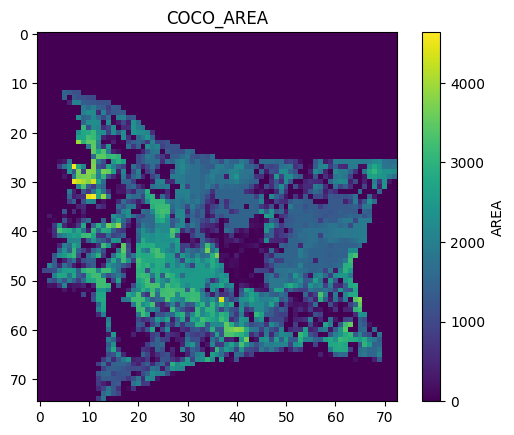

In [8]:
# Read the raster data
data = dataset.ReadAsArray()

# Plot the raster data using matplotlib
plt.imshow(data, cmap='viridis')
plt.title('COCO_AREA')
plt.colorbar(label='AREA')
plt.show()



In [26]:
#Alternatively Open IMage with rasterio
dataset_rasterio = rasterio.open(path)

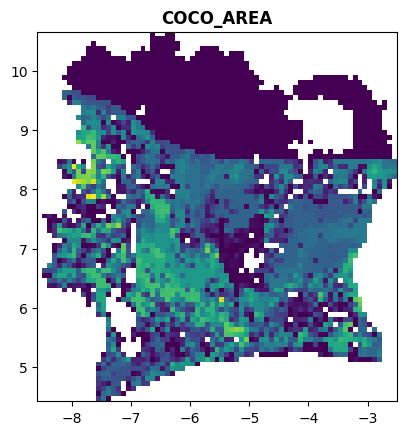

In [27]:
# Plot it
show(dataset_rasterio, cmap='viridis', title='COCO_AREA')
plt.show()



In [71]:

def K_means_images(dataset, n_clusters, best_classes):
    # Read the raster data
    data = dataset.read()

    # Reshape to one channel
    reshaped_data = data.reshape(-1, 1)

    # k-means clustering 
    #n_clusters = 6
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(reshaped_data)
    cluster_labels = kmeans.labels_
    
    # Reshape the clustered labels back to the original image shape
    clustered_image = cluster_labels.reshape(data.shape)
    
    # Find the two most dominant clusters
    dominant_clusters = np.argsort(np.bincount(cluster_labels))[::-1][:2]
    '''didnt added best_classes, as value to control the count of the best taken classes'''

    # Mask the image to keep only pixels corresponding to the two dominant clusters
    masked_image = np.where(np.isin(clustered_image, dominant_clusters), clustered_image, np.nan)

    # Squeeze dimension in the data array
    #data_squeezed = np.squeeze(data)

    # Return both Images
    return data, clustered_image, masked_image




In [72]:
#call k_means_images
original, kmeans, best = K_means_images(dataset_rasterio,6,2)

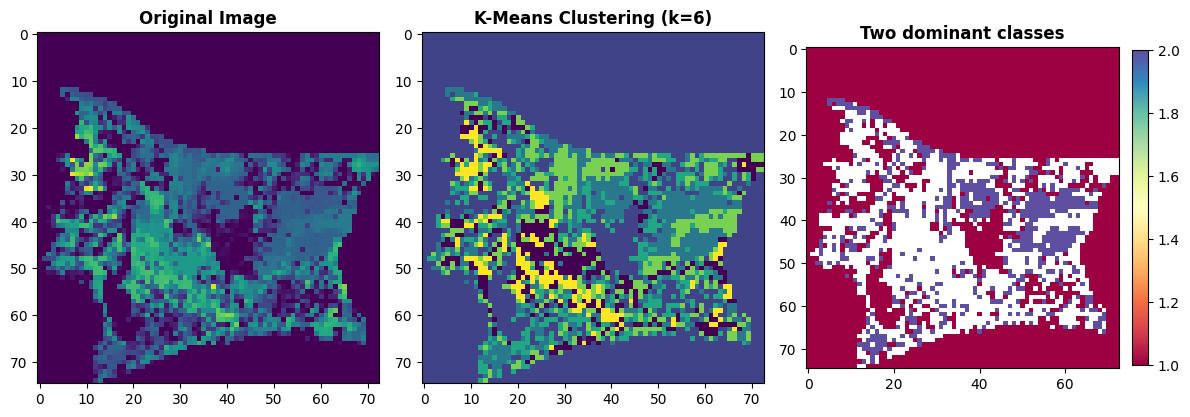

In [74]:
#lets plot it 

# Plot the original and clustered images side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,6))

# Original image
show(data, ax=ax1, cmap='viridis', title='Original Image')

# Clustered image
show(kmeans, ax=ax2, cmap='viridis', title='K-Means Clustering (k=6)')

# masked image
show(best, ax=ax3, cmap='Spectral', title='Two dominant classes')

# Add colorbar 
cbar = fig.colorbar(ax3.images[0], ax=ax3, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('')

plt.tight_layout()
plt.show()


#plt.show()

In [75]:

def get_centroids_geotiff(dataset):
 
    # Get the geotransform parameters
    geotransform = dataset.GetGeoTransform()
    top_left_x, pixel_width, _, top_left_y, _, pixel_height = geotransform

    # Get number of rows and columns 
    rows, cols = dataset.RasterYSize, dataset.RasterXSize

    # lists to store centroid coordinates
    centroids_x = []
    centroids_y = []

    # Calculate centroids for each pixel
    for i in range(rows):
        for j in range(cols):
            centroid_x = top_left_x + j * pixel_width + pixel_width / 2.0
            centroid_y = top_left_y + i * pixel_height + pixel_height / 2.0
            centroids_x.append(centroid_x)
            centroids_y.append(centroid_y)

    # Convert to NumPy arrays
    centroids_x = np.array(centroids_x)
    centroids_y = np.array(centroids_y)

    # Create a DataFrame
    df = pd.DataFrame({'Centroid_X': centroids_x, 'Centroid_Y': centroids_y})

    dataset = None

    return df



In [78]:
# Example
centroids = get_centroids_geotiff(dataset)
print(centroids_df.head())

   Centroid_X  Centroid_Y
0   -8.542352   10.625317
1   -8.459019   10.625317
2   -8.375686   10.625317
3   -8.292353   10.625317
4   -8.209020   10.625317


In [85]:

def Values_centroids(centroids, clustered_image, original_image):

    # Reshape centroids
    #centroids = centroids.reshape(-1, centroids.shape[-1])

    # Get the coordinates of centroids
    num_centroids = centroids.shape[0]
    centroid_coords = np.array([(i, j) for i in range(clustered_image.shape[0]) for j in range(clustered_image.shape[1])])

    # Get the original values corresponding to centroids
    original_values = original_image[centroid_coords[:, 0], centroid_coords[:, 1]]

    # Get the class labels corresponding to centroids
    class_labels = clustered_image[centroid_coords[:, 0], centroid_coords[:, 1]]

    # Create DataFrame
    df = pd.DataFrame({
        'Centroid_X': centroids[:, 0],
        'Centroid_Y': centroids[:, 1],
        'Original_Value': original_values,
        'Class_Label': class_labels
    })

    return df


In [86]:
# 
Values_centroids(centroids, kmeans, data)
#data kmeans best

IndexError: index 10 is out of bounds for axis 0 with size 1

In [89]:


def centroids_to_dataframe(centroids_df, clustered_image, original_image):
    """
    Convert centroids DataFrame to a DataFrame with their coordinates, original values,
    and corresponding class labels from clustering.

    Parameters:
    - centroids_df (pandas.DataFrame): DataFrame containing the centroids.
    - clustered_image (numpy.ndarray): Array containing the class labels from clustering.
    - original_image (numpy.ndarray): Array containing the original image values.

    Returns:
    - pandas.DataFrame: DataFrame containing centroids' coordinates, original values,
      and class labels.
    """
    # Get the coordinates of centroids
    centroid_coords = centroids_df[['Centroid_X', 'Centroid_Y']].values

    # Get the original values corresponding to centroids
    original_values = original_image[centroid_coords[:, 1].astype(int), centroid_coords[:, 0].astype(int)]

    # Get the class labels corresponding to centroids
    class_labels = clustered_image[centroid_coords[:, 1].astype(int), centroid_coords[:, 0].astype(int)]

    # Add original values and class labels to the centroids DataFrame
    centroids_df['Original_Value'] = original_values
    centroids_df['Class_Label'] = class_labels

    return centroids_df


In [92]:
def centroids_to_dataframe(centroids_df, clustered_image, original_image):
    """
    Convert centroids DataFrame to a DataFrame with their coordinates, original values,
    and corresponding class labels from clustering.

    Parameters:
    - centroids_df (pandas.DataFrame): DataFrame containing the centroids.
    - clustered_image (numpy.ndarray): Array containing the class labels from clustering.
    - original_image (numpy.ndarray): Array containing the original image values.

    Returns:
    - pandas.DataFrame: DataFrame containing centroids' coordinates, original values,
      and class labels.
    """
    # Get the coordinates of centroids
    centroid_coords = centroids_df[['Centroid_X', 'Centroid_Y']].values

    # Convert centroid coordinates to integers
    centroid_coords = centroid_coords.astype(int)

    # Get the original values corresponding to centroids
    original_values = original_image[centroid_coords[:, 1], centroid_coords[:, 0]]

    # Get the class labels corresponding to centroids
    class_labels = clustered_image[centroid_coords[:, 1], centroid_coords[:, 0]]

    # Add original values and class labels to the centroids DataFrame
    centroids_df['Original_Value'] = original_values
    centroids_df['Class_Label'] = class_labels

    return centroids_df


In [ ]:
def centroids_to_dataframe(centroids_df, clustered_image, original_image):
    """
    Convert centroids DataFrame to a DataFrame with their coordinates, original values,
    and corresponding class labels from clustering.

    Parameters:
    - centroids_df (pandas.DataFrame): DataFrame containing the centroids.
    - clustered_image (numpy.ndarray): Array containing the class labels from clustering.
    - original_image (numpy.ndarray): Array containing the original image values.

    Returns:
    - pandas.DataFrame: DataFrame containing centroids' coordinates, original values,
      and class labels.
    """
    # Get the coordinates of centroids
    centroid_coords = centroids_df[['Centroid_X', 'Centroid_Y']].values

    print("Centroid coordinates:")
    print(centroid_coords)

    # Convert centroid coordinates to integers
    centroid_coords = centroid_coords.astype(int)

    print("Centroid coordinates (after conversion to integers):")
    print(centroid_coords)

    # Get the original values corresponding to centroids
    print("Original image shape:", original_image.shape)
    print("Centroid coordinates shape:", centroid_coords.shape)
    original_values = original_image[centroid_coords[:, 1], centroid_coords[:, 0]]

    # Get the class labels corresponding to centroids
    class_labels = clustered_image[centroid_coords[:, 1], centroid_coords[:, 0]]

    # Add original values and class labels to the centroids DataFrame
    centroids_df['Original_Value'] = original_values
    centroids_df['Class_Label'] = class_labels

    return centroids_df


In [93]:
test=centroids_to_dataframe(centroids, kmeans, data)

IndexError: index 10 is out of bounds for axis 0 with size 1